# Pre processing
Ce notebook présente l'exploration de nos données ainsi que les traitements de nettoyage afin de fournir nos données au format optimal piur notre classifieur.   
Le notebook télécharge les données puis effectue les transformations. Il suffit d'éxécuter l'intégralité des cellules dans l'ordre pour terminer le pré-processing.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import requests
import zipfile
from PIL import Image
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random
import math

## 0. Variables
Définition des paramètres du pré-processing.

In [ ]:
random.seed(123)

download_url = "https://viacesifr-my.sharepoint.com/:u:/g/personal/armand_debesse_viacesi_fr/Efhh8ZEjkt9Iqbeb_Tx11rUBL5FXsOQISqiJUxzMOEZx0Q?download=1"

sources_directory = "./OneDrive_2022-09-22/"
sources_categories = ['Photo', 'Painting', 'Schematics', 'Sketch', 'Text']

process_directory = "./processed_data/"

image_valid_extensions = [".png", ".jpg", ".jpeg"]
image_target_size = (150, 150)

## 1. Chargement des données dans un dataframe
La première étape consiste à charger nos données brut afin de les explorer.

### 1.1. Téléchargement des données

In [ ]:
def download_and_unzip(url, filename="downloaded.zip"):
    """
    Downloads a zip file from the given URL and unzips it in the current directory.

    Parameters:
    - url: The URL of the zip file to download.
    - filename: The name to give to the downloaded file (optional).

    Returns:
    - None
    """
    chunk_size = 8*1024
    
    response = requests.get(url, stream=True)
    total_size = int(response.headers["Content-Length"])
    with open(filename, 'wb') as file:
        with tqdm(desc="Downloading dataset", total=total_size, unit_scale=True, unit="B", unit_divisor=1024) as t:
            for chunk in response.iter_content(chunk_size=chunk_size):
                file.write(chunk)
                t.update(len(chunk))
                
    print("Extracting...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extracted")

    print("Cleaning...")
    os.remove(filename)
    print("Cleaned")

In [ ]:
if True:
    download_and_unzip(download_url)

Extracting...
Extracted
Cleaning...
Cleaned


### 1.2. Création du dataframe

In [ ]:
def load_dataframe(root_dir, categories):
    data = []

    for category in categories:
        category_path = os.path.join(root_dir, category)
        
        for img_file in os.listdir(category_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):  
                img_path = os.path.join(category_path, img_file)
                label = category
                data.append((img_path, label))

    df = pd.DataFrame(data, columns=['image_path', 'label'])
    return df

In [ ]:
df = load_dataframe(sources_directory, sources_categories)
df.head()

,image_path,label
0,./OneDrive_2022-09-22/Photo\photo_0001.jpg,Photo
1,./OneDrive_2022-09-22/Photo\photo_0002.jpg,Photo
2,./OneDrive_2022-09-22/Photo\photo_0003.jpg,Photo
3,./OneDrive_2022-09-22/Photo\photo_0004.jpg,Photo
4,./OneDrive_2022-09-22/Photo\photo_0005.jpg,Photo


### 1.3. Visualisation des données
Affichage de 5 photos aléatoires pour chaque label.

In [ ]:
def display_random_images(df, num_images=5):
    # Récupérer les labels uniques
    unique_labels = df['label'].unique()
    
    # Pour chaque label unique
    for label in unique_labels:
        # Sélectionner `num_images` entrées aléatoires pour ce label
        sample_df = df[df['label'] == label].sample(num_images)
        
        # Afficher les images
        plt.figure(figsize=(3*num_images, 3))
        for i, row in sample_df.iterrows():
            img = mpimg.imread(row['image_path'])
            plt.subplot(1, num_images, i % num_images + 1)
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

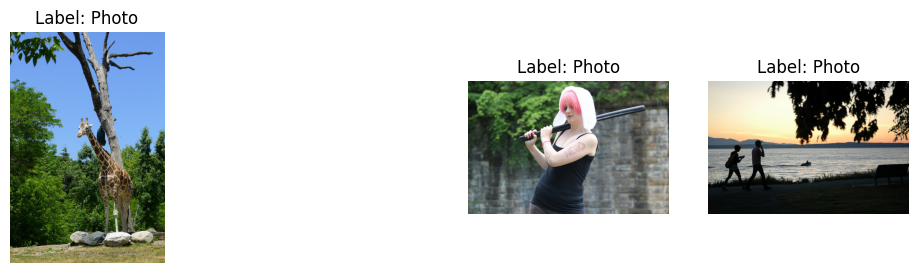

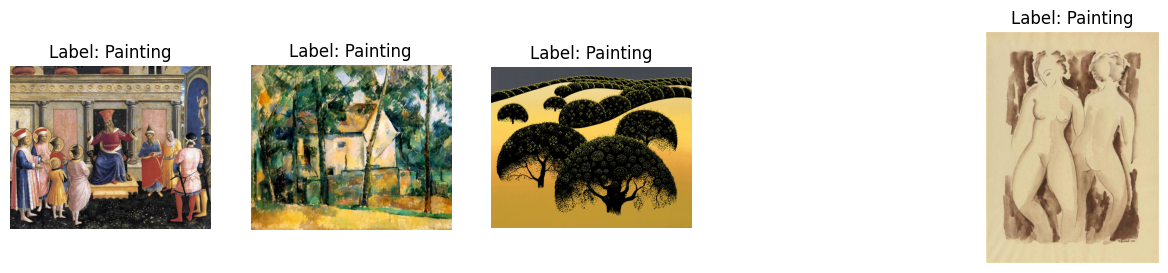

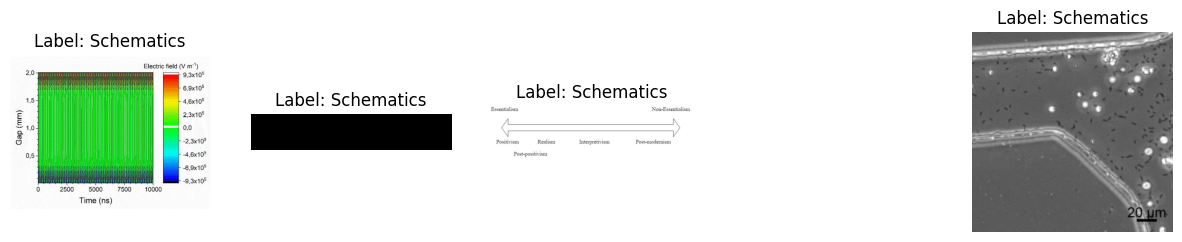

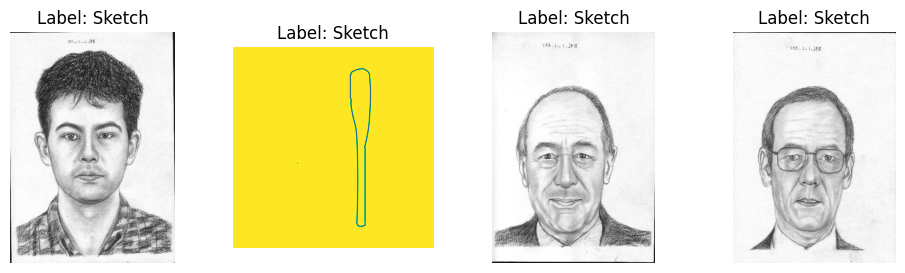

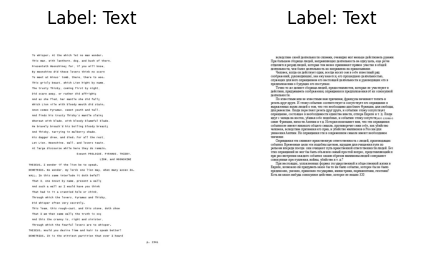

In [ ]:
display_random_images(df)

## 2. Analyse des données

In [ ]:
def get_dataframe_statistics(df: pd.DataFrame):    
    # Dictionnaire pour conserver un décompte des modes d'image
    modes_count = {}
    
    # Listes pour conserver les largeurs et les hauteurs des images
    sizes_by_label = {label: {'widths': [], 'heights': []} for label in df['label'].unique()}
    
    # Créez un dictionnaire pour stocker les valeurs de pixels pour chaque label
    pixels_by_label = {label: {} for label in df['label'].unique()}
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Getting values from images"):
        image_path, label = row['image_path'], row['label']
        
        # Essayez d'ouvrir le fichier comme une image
        try:
            with Image.open(image_path) as img:
                # Analyse les modes des images
                mode = img.mode
                modes_count[mode] = modes_count.get(mode, 0) + 1
                
                # Analyse les tailles des images
                w, h = img.size
                sizes_by_label[label]['widths'].append(w)
                sizes_by_label[label]['heights'].append(h)
                
                # Renvoie les valeurs de pixel d'une image en niveaux de gris.
                grayscale = img.convert("L")
                grayscale = np.array(grayscale).flatten()
                pixel_value, value_count = np.unique(grayscale, return_counts=1)
                for i in range(len(pixel_value)):
                    pixels_by_label[label][pixel_value[i]] = pixels_by_label[label].get(pixel_value[i], 0) + value_count[i]
        except Exception as e:
            print(f"Couldn't process image {image_path} due to {e}")
            
    return (modes_count, sizes_by_label, pixels_by_label)

In [ ]:
df_modes_count, df_sizes_by_label, df_pixels_by_label = get_dataframe_statistics(df)

Getting values from images:   0%|          | 0/41399 [00:00<?, ?it/s]

### 2.1. Répartition des valeurs de Pixels par label
L'étude de la répartition des valeurs des pixels des images de chaque catégories nous permet de mieux comprendre notre jeu de données.   
Analyser la distribution des valeurs des pixels peut révéler des caractéristiques intrinsèques des images de chaque catégorie.   
Par exemple, on peut voir ici que les textes et les dessins sont essentiellement composés de pixels noirs et blancs. Cette information peut expliquer que le modèle ecarte facilement les images qui appartiennent à ces catégories car les photos sont généralement en couleur. En revanche, des photos en noir et blanc pourraient être écartées car confondues avec ces catégories.

In [ ]:
def plot_pixel_distribution(pixels_by_label):    

    # Créez un histogramme pour les canaux de couleur (Rouge, Vert, Bleu) avec des portions de 20 unités
    bin_width = 20
    bins = range(0, 256, bin_width)

    # Créez un sous-traceur pour chaque label et chaque canal de couleur
    fig, axs = plt.subplots(len(pixels_by_label), 3, figsize=(15, 6 * len(pixels_by_label)), sharex=True)

    # Parcourez les labels et tracez les histogrammes pour chaque canal de couleur
    for i, (label, pixel_counts) in enumerate(pixels_by_label.items()):
        r_counts = [pixel_counts['R'][pixel] for pixel in range(0, 256, bin_width)]
        g_counts = [pixel_counts['G'][pixel] for pixel in range(0, 256, bin_width)]
        b_counts = [pixel_counts['B'][pixel] for pixel in range(0, 256, bin_width)]

        ax_r = axs[i][0]
        ax_g = axs[i][1]
        ax_b = axs[i][2]

        ax_r.bar(bins[:-1], r_counts, width=bin_width, color='red', alpha=0.7)
        ax_g.bar(bins[:-1], g_counts, width=bin_width, color='green', alpha=0.7)
        ax_b.bar(bins[:-1], b_counts, width=bin_width, color='blue', alpha=0.7)

        ax_r.set_title(f'Label {label} - Rouge')
        ax_g.set_title(f'Label {label} - Vert')
        ax_b.set_title(f'Label {label} - Bleu')

        ax_r.set_xlabel('Valeur de pixel')
        ax_g.set_xlabel('Valeur de pixel')
        ax_b.set_xlabel('Valeur de pixel')

        ax_r.set_ylabel('Nombre de pixels')
        ax_g.set_ylabel('Nombre de pixels')
        ax_b.set_ylabel('Nombre de pixels')

    plt.tight_layout()
    plt.show()

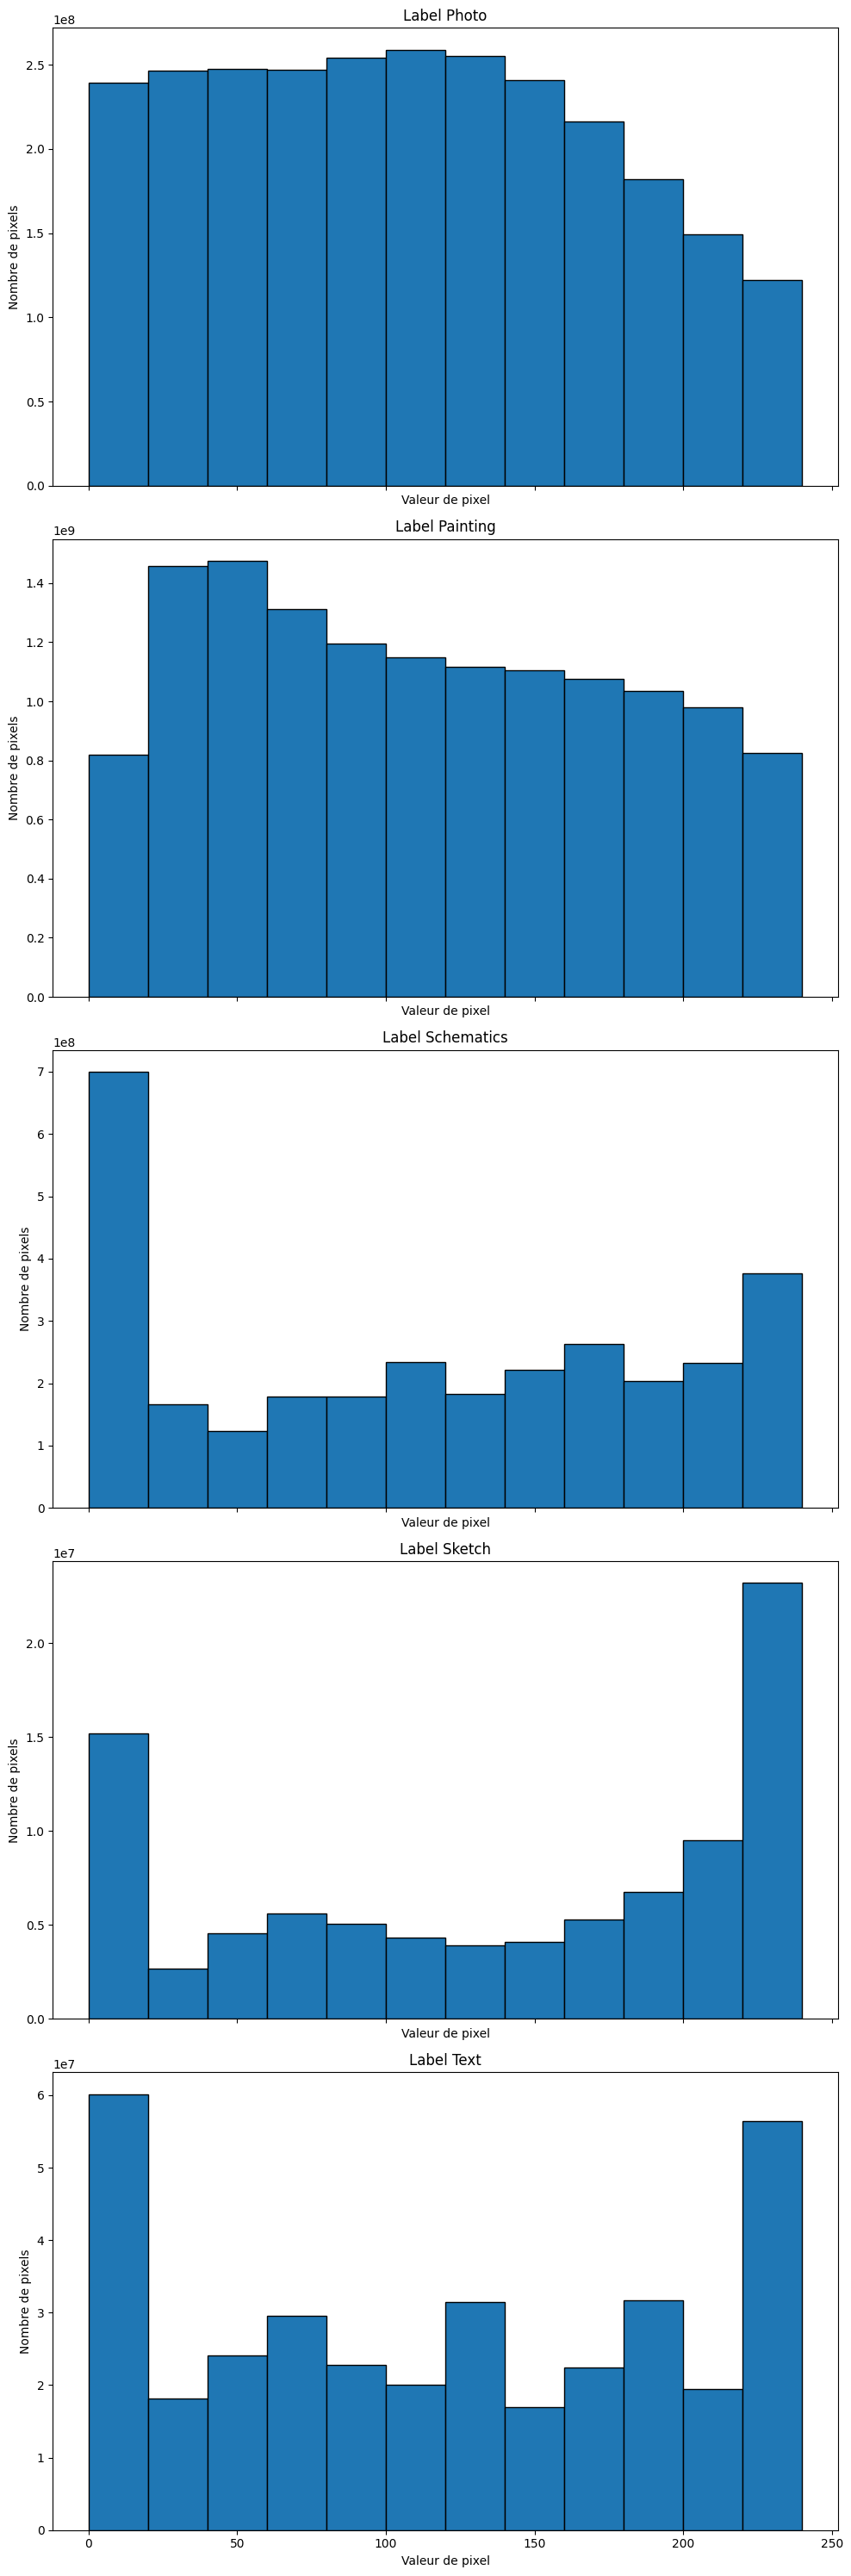

In [ ]:
plot_pixel_distribution(df_pixels_by_label)

### 2.2. Types de couleurs
Afin d'assurer la cohérence de nos données, il est important que toutes les images soient encodées selon le même type de couleur. Cela assurera que le modèle évalue chaque donnée de la même manière.

In [ ]:
def analyze_image_modes(modes_count):
    """Analyse les modes des images depuis un dataframe, affiche leur distribution, 
    et imprime le décompte précis pour chaque mode."""
    
    # Afficher la distribution des modes d'image
    modes = list(modes_count.keys())
    counts = list(modes_count.values())
    
    plt.bar(modes, counts, color='skyblue')
    plt.xlabel('Mode d\'image')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition des modes d\'image')
    plt.show()
    
    # Afficher le nombre précis pour chaque mode
    for mode, count in modes_count.items():
        print(f"Mode {mode}: {count} images")

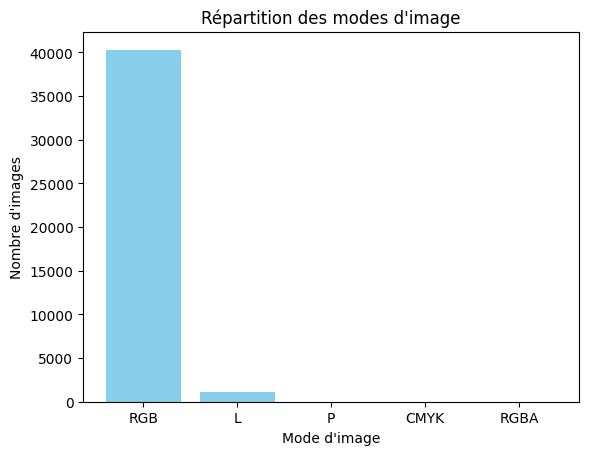

Mode RGB: 40297 images
Mode L: 1091 images
Mode P: 5 images
Mode CMYK: 1 images
Mode RGBA: 5 images


In [ ]:
analyze_image_modes(df_modes_count)

On peut voir ici que la majorité des images ont au format RGB. Cependant il a aussi d'autres formats. Il sera donc nécéssaire de transformer toutes les images au format RGB.

### 2.3. Taille des images

In [ ]:
def analyze_image_sizes(sizes_by_label):
    """Analyse les tailles des images depuis un dataframe et affiche leur distribution."""
    
    # Afficher la distribution des tailles d'image
    plt.figure(figsize=(10, 6))
    for label, sizes in sizes_by_label.items():
        plt.scatter(sizes['widths'], sizes['heights'], alpha=0.3, marker=".", label=label)
    plt.xlabel('Largeur de l\'image')
    plt.ylabel('Hauteur de l\'image')
    plt.title('Répartition des tailles d\'image')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.legend()
    plt.show()

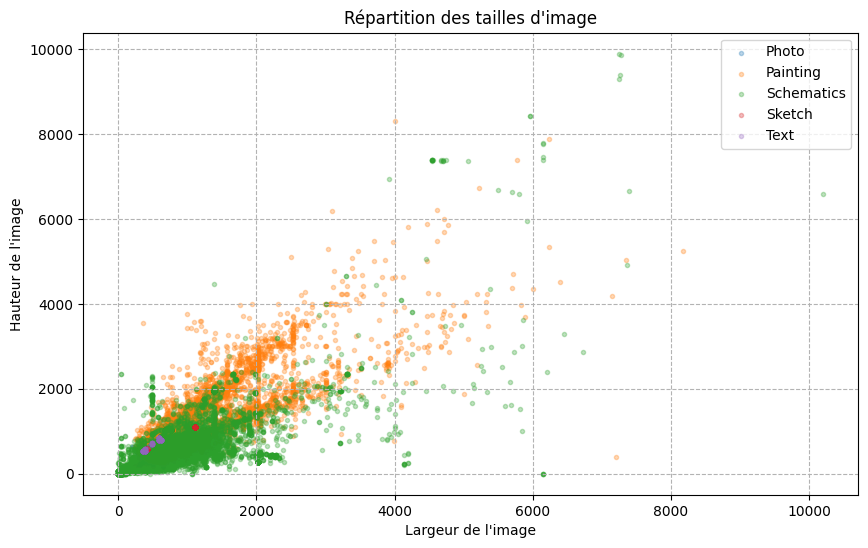

In [ ]:
analyze_image_sizes(df_sizes_by_label)

### 2.4. Ratio des images

In [ ]:
def get_image_ratios(sizes_by_label):
    """Retourne les ratios des images depuis un dataframe."""
    widths = []
    heights = []
    for sizes in sizes_by_label.values():
        widths.extend(sizes['widths'])
        heights.extend(sizes['heights'])
    ratios = np.array(widths) / np.array(heights)
    return ratios

In [ ]:
def analyze_image_ratios(ratios):
    """Analyse les ratios des images depuis un dataframe et affiche leur distribution."""
    
    # Afficher la distribution des ratios d'image à l'aide d'un diagramme en boîte
    plt.figure(figsize=(10, 6))
    plt.boxplot(ratios, vert=False)
    plt.xlabel('Ratio (Largeur / Hauteur)')
    plt.title('Distribution des ratios d\'image')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

In [ ]:
def plot_high_ratios(ratios, threshold=20):
    """Affiche les ratios supérieurs à un certain seuil dans un nuage de points."""

    # Filtrer les ratios
    high_ratios = [ratio for ratio in ratios if ratio > threshold]

    # Créer un scatter plot pour ces ratios
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(high_ratios)), high_ratios, color='blue', marker='o')
    plt.ylabel('Ratio (Largeur / Hauteur)')
    plt.title(f'Ratios d\'image supérieurs à {threshold}')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

In [ ]:
df_ratios = get_image_ratios(df_sizes_by_label)

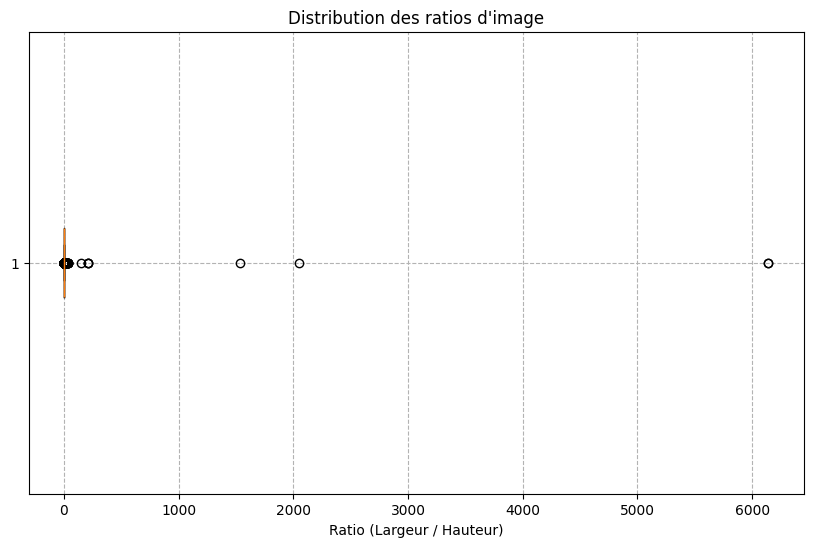

In [ ]:
analyze_image_ratios(df_ratios)

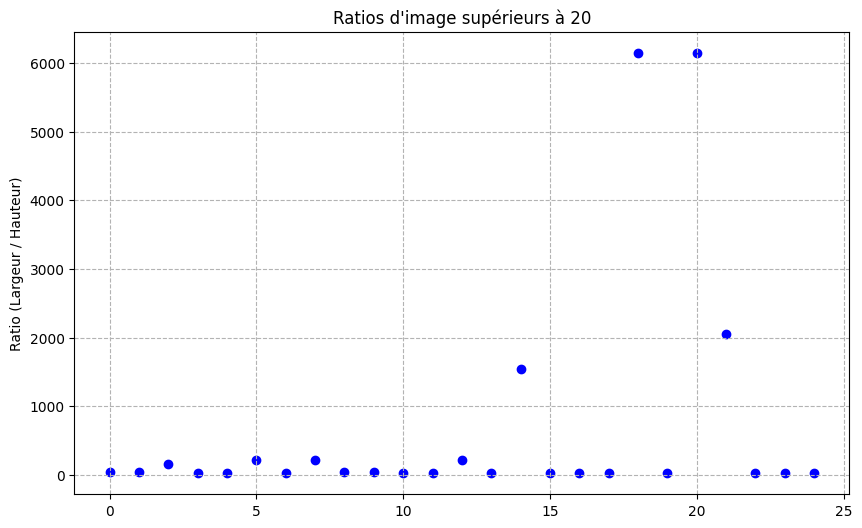

In [ ]:
plot_high_ratios(df_ratios, 20)

### 2.5. Répartition des classes

In [ ]:
def class_distribution(df):
    """
    Plots the distribution of classes (labels) in the given DataFrame.

    Parameters:
    - df: DataFrame containing the labels.

    Returns:
    - None
    """
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(10,6))
    label_counts.plot(kind='bar')
    plt.title('Répartition des labels')
    plt.xlabel('Labels')
    plt.ylabel('Nombre d\'images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

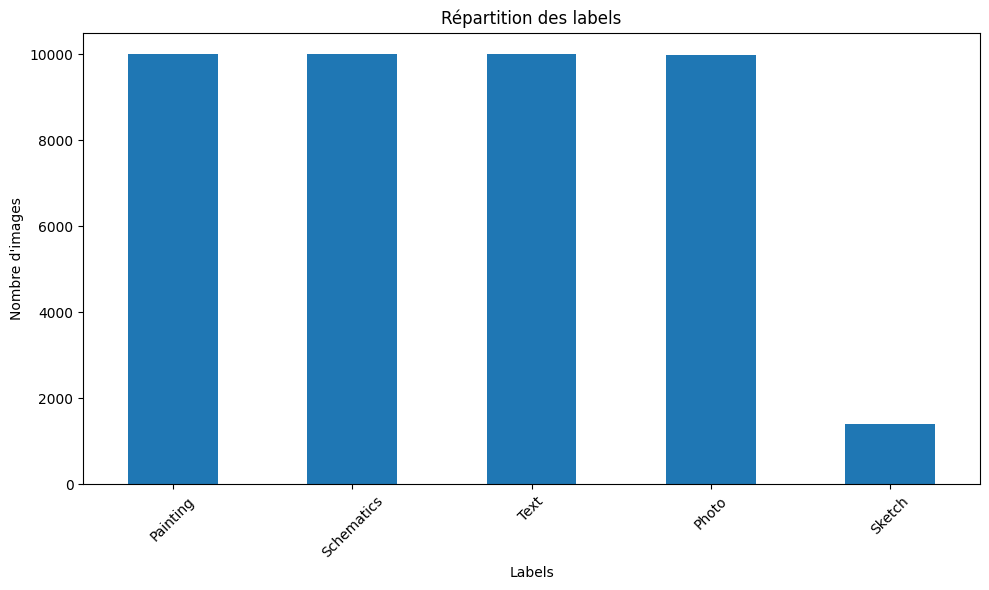

In [ ]:
class_distribution(df)

## 3. Nettoyage des données

### 3.3. Augmentation des données

def augment_images(directory_path):
    for img_path in Path(directory_path).glob('aug_*'):
        os.remove(img_path)
        
    for file_name in tqdm(os.listdir(directory_path), desc="File"):    
        file_path = os.path.join(directory_path, file_name)    
        try:
            # Lire l'image avec TensorFlow
            image = tf.io.read_file(file_path)
            image = tf.image.decode_image(image, channels=3)

            # Créer des dérivés de l'image
            flipped_left_right = tf.image.flip_left_right(image)
            flipped_up_down = tf.image.flip_up_down(image)

            # Enregistrer les images dérivées
            flipped_lr_path = os.path.join(directory_path, f"aug_leftright_{file_name}")
            flipped_ud_path = os.path.join(directory_path, f"aug_updown_{file_name}")

            tf.io.write_file(flipped_lr_path, tf.image.encode_jpeg(flipped_left_right))
            tf.io.write_file(flipped_ud_path, tf.image.encode_jpeg(flipped_up_down))
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {file_path}: {e}")

In [ ]:
def augment_images(directory_path):
    for img_path in Path(directory_path).glob('aug_*'):
        os.remove(img_path)
    
    for file_name in tqdm(os.listdir(directory_path), desc="File"):    
        file_path = os.path.join(directory_path, file_name)    
        try:
            # Lire l'image avec TensorFlow
            image = tf.io.read_file(file_path)
            image = tf.image.decode_image(image, channels=3)
            img_height, img_width, _ = image.shape
            
            image = image.numpy().reshape((1,image.shape[0],image.shape[1],3))

            # Calculate the diagonal of the image
            diagonal = math.sqrt(pow(img_width, 2) + pow(img_height, 2))
            
            # Calculate the scale factor
            scale_factor = (min(img_width, img_height) / diagonal) - 0.1

            img_gen = ImageDataGenerator(
                rotation_range=45,
                zoom_range=[scale_factor - 0.2, scale_factor],
                horizontal_flip=True,
                fill_mode='wrap',
                validation_split=0
            ).flow(image, save_to_dir=directory_path, save_prefix='aug_' + os.path.basename(file_name).split('.')[0], save_format='jpeg')

            # Créer des augmentations pour une image et les enregistrer
            for batch in range(2):
                next(img_gen)

            
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {file_path}: {e}")

In [ ]:
augment_images(os.path.join(sources_directory, "Photo"))

File:   0%|          | 0/9993 [00:00<?, ?it/s]

### 3.1. Nettoyage et enregistrement des données nettoyées
Afin de rendre les données cohérentes pour notre modèle il convient de corriger les diparités étudiées précédemment.  
Pour cela, nous allons appliquer différentes opérations à nos images avant de les enregistrer dans processed-data.  
- Conversion des images en RGB
- Redimensionnement des images
- Vérification que les fichiers sont lisibles par tensorflow  
  
La normalisation des images est essentielle pour optimiser les performances de notre CNN. Cependant, nous différerons cette étape pour permettre l'enregistrement au format JPEG et garantir la compatibilité avec nos analyses précédentes, assurant ainsi la vérification correcte du traitement des données.


In [ ]:
def process_images(source_directory, destination_directory, target_size, valid_extensions):
    shutil.rmtree(destination_directory)
    
    # Créer le dossier de destination s'il n'existe pas
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for folder_name in tqdm(os.listdir(source_directory), desc="Directory", position=0):
        source_folder_path = os.path.join(source_directory, folder_name)
        if folder_name == "Photo":
            dest_folder_name = "photos"
        else:
            dest_folder_name = "not-photos"
            
        destination_folder_path = os.path.join(destination_directory, dest_folder_name)
        
        # Créer le sous-dossier dans le dossier de destination s'il n'existe pas
        if not os.path.exists(destination_folder_path):
            os.makedirs(destination_folder_path)
        
        for file_name in tqdm(os.listdir(source_folder_path), desc="File", position=1, leave=False):
            if any(file_name.endswith(extension) for extension in valid_extensions):
                source_file_path = os.path.join(source_folder_path, file_name)
                transient_file_path = os.path.join(destination_folder_path, "transient_" + file_name)
                destination_file_path = os.path.join(destination_folder_path, file_name)
                try:
                    # Convertir l'image en RGB et redimensionner avec PIL
                    with Image.open(source_file_path) as img:
                        img_rgb = img.convert('RGB')
                        img_resized = img_rgb.resize(target_size)
                        img_resized.save(transient_file_path, "JPEG")
                    
                    # Lire et vérifier l'image avec TensorFlow
                    image = tf.io.read_file(transient_file_path)
                    image = tf.image.decode_image(image)
                    
                    # Normaliser l'image
                    #image = tf.image.convert_image_dtype(image, tf.float32, saturate=True)
                    
                    # Enregistrer l'image traitée
                    encoded_image = tf.image.encode_jpeg(tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=True))
                    tf.io.write_file(destination_file_path, encoded_image)
                    
                except Exception as e:
                    print(f"Erreur lors du traitement de l'image {source_file_path}: {e}")
                
                if os.path.exists(transient_file_path):
                    os.remove(transient_file_path)

    print("Traitement terminé!")

In [ ]:
process_images(sources_directory, process_directory, image_target_size, image_valid_extensions)

### 3.2. Vérification des données

Chargement des données nettoyées

In [ ]:
cleanned_df = load_dataframe(process_directory, categories=["photos", "not-photos"])
cleanned_df.head()

In [ ]:
display_random_images(cleanned_df)

Types de couleurs

In [ ]:
cleanned_modes_count, cleanned_sizes_by_label, cleanned_pixels_by_label = get_dataframe_statistics(cleanned_df)

In [ ]:
analyze_image_modes(cleanned_modes_count)

Taille et ratio

In [ ]:
cleanned_ratios = get_image_ratios(cleanned_sizes_by_label)

In [ ]:
analyze_image_ratios(cleanned_ratios)

In [ ]:
plot_high_ratios(cleanned_ratios, 20)

Réppartition des classes

In [ ]:
class_distribution(cleanned_df)

Répartition des valeurs de Pixels par label

In [ ]:
plot_pixel_distribution(cleanned_pixels_by_label)